# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

Подгружаем необходимые библиотеки

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

Константы:

In [2]:
RS = 12345
STATE = np.random.RandomState(RS)
BUDGET = 10000000000 # общий бюджет на разработку
PART_BOREHOLES = 500 # количество точек исследования
BEST_BOREHOLES = 200 # количество скважин
INCOME_1 = 450000 # доход от одной единыцы т.е. 1 тыс. баррелей
PROBABILITY_OF_LOSSES = 0.025 # вероятность убытков

Посмотрим, что за сюрпризы приготовил Яндекс Практикум в файлах.

In [6]:
pth1 = 'geo_data_0.csv'
pth2 = 'geo_data_1.csv'
pth3 = 'geo_data_2.csv'

pth4 = '/datasets/geo_data_0.csv'
pth5 = '/datasets/geo_data_1.csv'
pth6 = '/datasets/geo_data_2.csv'

if os.path.exists(pth1) and os.path.exists(pth2) and os.path.exists(pth3):
    data_1 = pd.read_csv(pth1)
    data_2 = pd.read_csv(pth2)
    data_3 = pd.read_csv(pth3)
    
elif os.path.exists(pth4) and os.path.exists(pth5) and os.path.exists(pth6):
    data_1 = pd.read_csv(pth4)
    data_2 = pd.read_csv(pth5)
    data_3 = pd.read_csv(pth6)
else:
    print('Something is wrong')

Выведем размеры датафайлов.

In [7]:
print("Размер первого:", data_1.shape)
print("Размер второго:", data_2.shape)
print("Размер третьего:", data_3.shape)

Размер первого: (100000, 5)
Размер второго: (100000, 5)
Размер третьего: (100000, 5)


Файлы, на первый взгляд, - идентичны.

In [8]:
print(data_1.head())
print(data_2.head())
print(data_3.head())

      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647
      id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305
      id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746


In [9]:
print(data_1.isnull().sum())
print(data_2.isnull().sum())
print(data_3.isnull().sum())

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64


Пропусков нет, названия корректные, дубликатов нет. 

### Наличие явных дубликатов

In [10]:
print('Явные дyбликаты в первом датафрейме:', data_1.duplicated().sum())
print()
print('Явные дyбликаты во втором датафрейме:', data_2.duplicated().sum())
print()
print('Явные дyбликаты в третьем датафрейме:', data_3.duplicated().sum())

Явные дyбликаты в первом датафрейме: 0

Явные дyбликаты во втором датафрейме: 0

Явные дyбликаты в третьем датафрейме: 0


### Наличие неявных дубликатов

In [11]:
# проверка на наличие неявных дубликатов
print('НЕявные дубликаты в первом датафрейме:', len(data_1['id'].unique()))
print()
print('НЕявные дубликаты во втором датафрейме:', len(data_2['id'].unique()))
print()
print('НЕявные дубликаты в третьем датафрейме:', len(data_3['id'].unique()))

НЕявные дубликаты в первом датафрейме: 99990

НЕявные дубликаты во втором датафрейме: 99996

НЕявные дубликаты в третьем датафрейме: 99996


Проверка показала, что есть 10 дубликатов в первом датафрейме и по 4 во втором и в третьем. Т.к. в процентном соотношениие дубликаты занимают менее 1%, то с этими точками можно попрощаться.

In [12]:
# отчаянно дропаем дубликаты

def dup_drop(dataframe):
    return dataframe.drop_duplicates(subset = ['id'], keep='first')
    
data_1 = dup_drop(data_1)
data_2 = dup_drop(data_2)
data_3 = dup_drop(data_3)

# по образцу в отдельном файле у меня получилось удалить дубликаты. 
# вроде бы и тут тоже удалились повторные точки в каждом датафрейме.

### Удаление столбца id

In [13]:
# перед обучением удалим ненужный столбец с уникальным идентификатором скважины так как он не нужен для обучения
data_1 = data_1.drop(['id'], axis=1)
data_2 = data_2.drop(['id'], axis=1)
data_3 = data_3.drop(['id'], axis=1)

### Распределение запасов

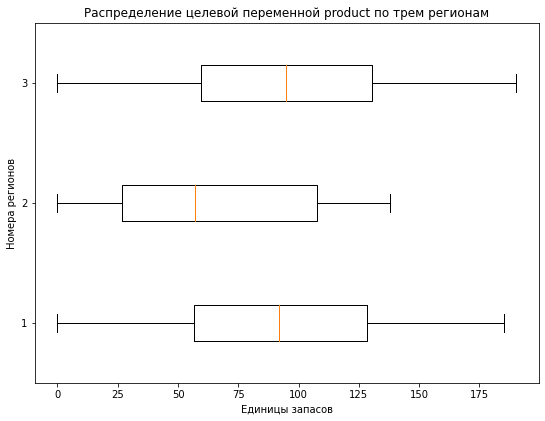

In [14]:
# визуализируем распределение запасов в каждом регионе
df_1 = data_1['product']
df_2 = data_2['product']
df_3 = data_3['product']

data = [df_1, df_2, df_3]
 
fig = plt.figure(figsize =(7, 5))

ax = fig.add_axes([0, 0, 1, 1])

bp = ax.boxplot(data, vert=False)
plt.xlabel('Единицы запасов')
plt.ylabel('Номера регионов')
plt.title('Распределение целевой переменной product по трем регионам')
plt.show()

Из вымученного усатого графика можно сделать вывод, что в 1 и 3 регионе запасы баррелей схожи, а вот второй регион имеет меньшие объёмы запасов.

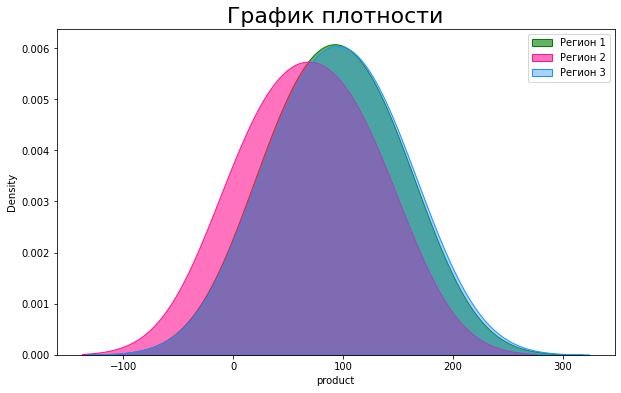

In [15]:
plt.figure(figsize=(10,6))
sns.kdeplot(df_1, shade=True, color="g", label="Регион 1", alpha=.6, bw_adjust=10)
sns.kdeplot(df_2, shade=True, color="deeppink", label="Регион 2", alpha=.6, bw_adjust=10)
sns.kdeplot(df_3, shade=True, color="dodgerblue", label="Регион 3", alpha=.4, bw_adjust=10)

# Decoration
plt.title('График плотности', fontsize=22)
plt.legend()
plt.show()

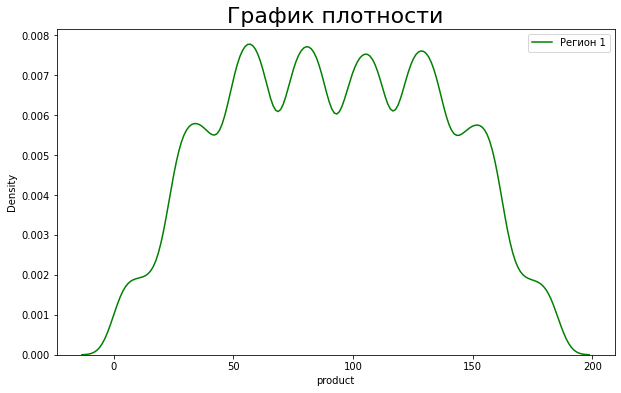

In [16]:
plt.figure(figsize=(10,6))
sns.kdeplot(df_1, color="g", label="Регион 1", alpha=.6)

# Decoration
plt.title('График плотности', fontsize=22)
plt.legend()
plt.show();

<Figure size 720x432 with 0 Axes>

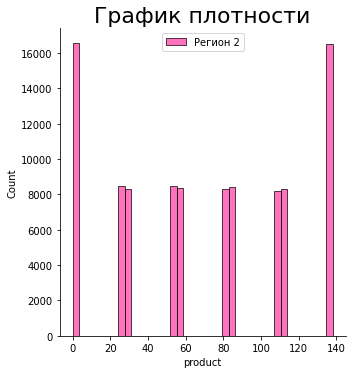

In [17]:
plt.figure(figsize=(10,6))
sns.displot(df_2, color="deeppink", label="Регион 2", alpha=.6)

# Decoration
plt.title('График плотности', fontsize=22)
plt.legend()
plt.show();

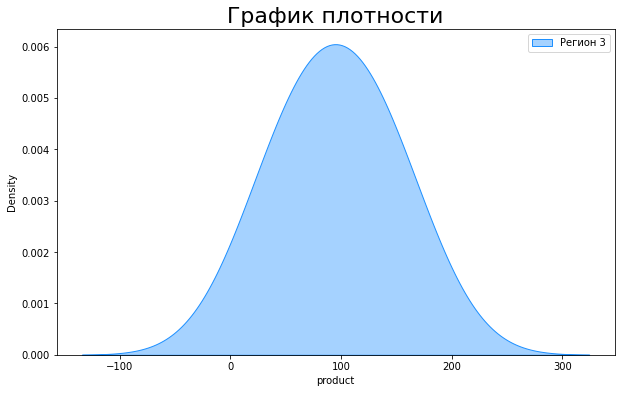

In [18]:
plt.figure(figsize=(10,6))
sns.kdeplot(df_3, shade=True, color="dodgerblue", label="Регион 3", alpha=.4, bw_adjust=10)

# Decoration
plt.title('График плотности', fontsize=22)
plt.legend()
plt.show()

### Корреляционный анализ

Text(0.5, 1.0, 'Корреляция Пирсона в первом регионе')

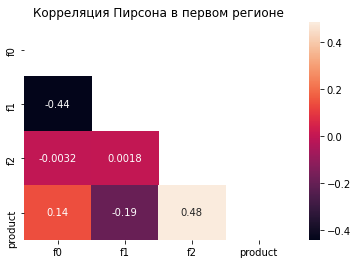

In [19]:
matrix = np.triu(data_1.corr())
sns.heatmap(data_1.corr(), annot = True,  mask=matrix)
plt.title('Корреляция Пирсона в первом регионе')

Text(0.5, 1.0, 'Корреляция Пирсона во втором регионе')

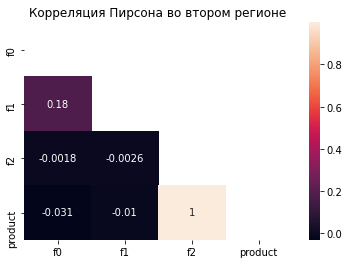

In [20]:
matrix = np.triu(data_2.corr())
sns.heatmap(data_2.corr(), annot = True,  mask=matrix)
plt.title('Корреляция Пирсона во втором регионе')

Text(0.5, 1.0, 'Корреляция Пирсона в третьем регионе')

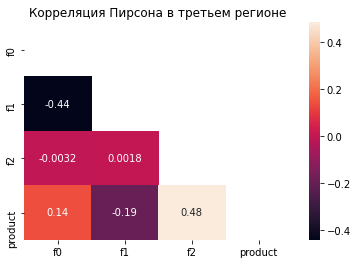

In [21]:
matrix = np.triu(data_1.corr())
sns.heatmap(data_1.corr(), annot = True,  mask=matrix)
plt.title('Корреляция Пирсона в третьем регионе')

### Промежуточный вывод после подготовки данных

При подготовке данных была проведена проверка на наличие пропусков, явных и неявных дубликатов. Дубликаты точек в каждом регине составили менее 1% от данных и были удалены из датафреймов.

Также был удален столбец с уникальным id каждой скважины, так как данная информация излишне для обучения моделей.

Из графика распределения данных, стало ясно, что во втором регионе запасов меньше чем в двух других. Однако при исследовании зависимости параметров от целевого признака выявилась ПРЯМАЯ зависимость f2 от целевого признака product.



## Обучение и проверка модели

### Разделим данные на выборки

Разделение на обучающую и валидационную выборки будет в соотношении 3:1, как сказано в задании.

In [22]:
# разделим каждый датафрейм на признаки features и целевой признак target:

data_1_features = data_1.drop(['product'], axis=1) # копируем все признаки, кроме целевого
data_1_target = data_1['product'] # целевой признак

data_2_features = data_2.drop(['product'], axis=1) # копируем все признаки, кроме целевого
data_2_target = data_2['product'] # целевой признак

data_3_features = data_3.drop(['product'], axis=1) # копируем все признаки, кроме целевого
data_3_target = data_3['product'] # целевой признак

Делим признаки и целевой признак исходных датасетов на две части в соотношении 3:1. Получим тренировочные выборки и тестовые.

In [23]:
data_1_features_train, data_1_features_test, data_1_target_train, data_1_target_test = train_test_split(
    data_1_features,
    data_1_target,
    test_size=0.25,
    random_state=RS
)

data_2_features_train, data_2_features_test, data_2_target_train, data_2_target_test = train_test_split(
    data_2_features,
    data_2_target,
    test_size=0.25,
    random_state=RS
)

data_3_features_train, data_3_features_test, data_3_target_train, data_3_target_test = train_test_split(
    data_3_features,
    data_3_target,
    test_size=0.25,
    random_state=RS
)

Функция для обучения модели:

In [24]:
def fit_func(features_train, target_train, features_test, target_test):
    model = LinearRegression()
    model.fit(features_train, target_train)
    prediction = model.predict(features_test)
    rmse = mean_squared_error(target_test, prediction) ** 0.5
    r2 = model.score(features_test, target_test)
    
    return model, prediction, rmse, r2

In [25]:
def print_model_params(model_number, prediction, rmse, r2):
    mean = prediction.mean()
    print(f'Модель для региона номер {model_number}:')
    print(f'- RMSE модели: {rmse}')
    print(f'- R2 модели: {r2}')
    print(f'- среднее предсказанного: {mean}')

### Обучение модели data_1

In [26]:
model_1, predictions_model_1, result_model_1, result_model_1_score = fit_func(
    data_1_features_train,
    data_1_target_train,
    data_1_features_test,
    data_1_target_test,
)

print_model_params(1, predictions_model_1, result_model_1, result_model_1_score)

Модель для региона номер 1:
- RMSE модели: 37.853527328872964
- R2 модели: 0.2723923460817068
- среднее предсказанного: 92.78915638280621


### Обучение модели data_2

In [27]:
model_2, predictions_model_2, result_model_2, result_model_2_score = fit_func(
    data_2_features_train,
    data_2_target_train,
    data_2_features_test,
    data_2_target_test,
)

print_model_params(2, predictions_model_2, result_model_2, result_model_2_score)

Модель для региона номер 2:
- RMSE модели: 0.892059264771703
- R2 модели: 0.9996222988190184
- среднее предсказанного: 69.17831957030432


### Обучение модели data_3

In [28]:
model_3, predictions_model_3, result_model_3, result_model_3_score = fit_func(
    data_3_features_train,
    data_3_target_train,
    data_3_features_test,
    data_3_target_test,
)

print_model_params(3, predictions_model_3, result_model_3, result_model_3_score)

Модель для региона номер 3:
- RMSE модели: 40.07585073246016
- R2 модели: 0.19556241810202346
- среднее предсказанного: 94.86572480562035


**Вывод:**


R2 во всех случаях больше нуля, это лучше чем, если бы значения R2 были отрицательными.
У второй модели R2 близка к 1, это, как "говорит" теория из практикума, очень даже неплохо, но скорее всего это из-за выявленной зависимости одного из признаков от целевого.


## Подготовка к расчёту прибыли

Заполним все ключевые значения для расчётов.

In [29]:
min_income = BUDGET/BEST_BOREHOLES # минимальный доход от одной точки
min_product = BUDGET/(BEST_BOREHOLES*INCOME_1) # минимальный объем единиц от одной точки
print('Минимальный объем в 1 скважине должен быть:', min_product, "единиц.")

Минимальный объем в 1 скважине должен быть: 111.11111111111111 единиц.


In [30]:
print('Средний запас предсказанного сырья в регионе 1:', predictions_model_1.mean())
print('Средний запас предсказанного сырья в регионе 2:', predictions_model_2.mean())
print('Средний запас предсказанного сырья в регионе 3:', predictions_model_3.mean())

Средний запас предсказанного сырья в регионе 1: 92.78915638280621
Средний запас предсказанного сырья в регионе 2: 69.17831957030432
Средний запас предсказанного сырья в регионе 3: 94.86572480562035


Из полученных данных, можно сделать вывод, что средний предсказанный каждой моделью в каждом регионе запас меньше чем достаточный минимальный объем для безубыточной разработки новой скважины, но это среднее значение, поэтому если выбрать максимальные точки, то есть шанс безубыточной разработки скважин добычи нефти.

## Расчёт прибыли и рисков 

Из слака, я узнала, что зачем-то нужно сбросить индексы.

In [31]:
# сброс индексов 
data_1_target_test = data_1_target_test.reset_index(drop=True)
data_2_target_test = data_2_target_test.reset_index(drop=True)
data_3_target_test = data_3_target_test.reset_index(drop=True)

# создадим series
predictions_model_1 = pd.Series(predictions_model_1)
predictions_model_2 = pd.Series(predictions_model_2)
predictions_model_3 = pd.Series(predictions_model_3)

Функция для расчета прибыли по выбранным скважинам и предсказаниям модели:

In [32]:
def revenue(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return INCOME_1*selected.sum() - BUDGET

In [33]:
def bootstrap_magic(target_test, prediction):
    values = []
    for i in range(1000):
        target_subsample = target_test.sample(
            n=PART_BOREHOLES,
            replace=True,
            random_state=STATE,
        )
        
        probs_subsample = prediction[target_subsample.index]
        
        values.append(revenue(target_subsample, probs_subsample, BEST_BOREHOLES))
                                  
    return pd.Series(values)

In [34]:
def bootstrap_print(values):
    mean_sum = values.mean()             
    mean_rev = values.mean()/BEST_BOREHOLES         
                      
    print(f'Средняя сумма доходов от 200 месторождений: {mean_sum*(10**(-6))} млн рублей')
    print(f'Средний доход от одного месторождения: {mean_rev*(10**(-6))} млн рублей')
    

Находим распределение прибыли для **первого** региона.

In [35]:
values_1 = bootstrap_magic(data_1_target_test, predictions_model_1)
bootstrap_print(values_1)

Средняя сумма доходов от 200 месторождений: 409.42803862143603 млн рублей
Средний доход от одного месторождения: 2.04714019310718 млн рублей


Находим распределение прибыли для **второго** региона.

In [36]:
values_2 = bootstrap_magic(data_2_target_test, predictions_model_2)
bootstrap_print(values_2)

Средняя сумма доходов от 200 месторождений: 536.400199435103 млн рублей
Средний доход от одного месторождения: 2.682000997175515 млн рублей


Находим распределение прибыли для **третьего** региона.

In [37]:
values_3 = bootstrap_magic(data_3_target_test, predictions_model_3)
bootstrap_print(values_3)

Средняя сумма доходов от 200 месторождений: 339.4780341977997 млн рублей
Средний доход от одного месторождения: 1.6973901709889982 млн рублей


Вывод

~Лучше заниматься добычей нефти, а не работать в школе, как я.~

По полученным данным видно, что в каждом из трех регионов выгодна разработка месторождений т.к. доходы превышают расходы на разработку. 

In [38]:
def estimate_risks(values, region_number):
    lower = values.quantile(PROBABILITY_OF_LOSSES)*(10**(-6))
    hight = values.quantile(0.975)*(10**(-6))
    
    print(f"Для региона {region_number}:")
    print("- 2,5%-квантиль: {:.6f} млн.руб.".format(lower))
    print("- 97,5%-квантиль: {:.6f} млн.руб.".format(hight))
    print("- Вероятность убытков: {:.2%}".format(len(values.loc[values<0])/len(values)))
    print("-"*60)

In [39]:
estimate_risks(values_1, 1)
estimate_risks(values_2, 2)
estimate_risks(values_3, 3)

Для региона 1:
- 2,5%-квантиль: -131.536029 млн.руб.
- 97,5%-квантиль: 944.395583 млн.руб.
- Вероятность убытков: 7.10%
------------------------------------------------------------
Для региона 2:
- 2,5%-квантиль: 112.954247 млн.руб.
- 97,5%-квантиль: 998.504157 млн.руб.
- Вероятность убытков: 0.30%
------------------------------------------------------------
Для региона 3:
- 2,5%-квантиль: -224.089222 млн.руб.
- 97,5%-квантиль: 847.067588 млн.руб.
- Вероятность убытков: 11.80%
------------------------------------------------------------


## "Вывод"

В ходе данного исследования передо мной стояла задача выбрать регион для бурения новых скважин.

Для решения данной задачи было сделано следующее:

1) Подготовлены данные трех регионов для обучения моделей (проверка пропусков, удаление не нужных значений, проверка типов данных, **была проведена работа с дубликатами в каждом регоне). Было выявлено высокое значение корреляции между признаком f2 и целевым признаком**. 

2) Для обучения трех моделей каждый датасет был разделен на обучающую (75%) и тестовую (25%) выборки.

3) Обучены три модели линейной регрессии для предсказания объема единиц в каждой точке всех трех регионов. . 

4) Проведена процедура Bootstrap с указанными в задании условиями. Результаты которой вместе с экономической частью показали результаты:

а) если выбрать 200 месторождений в каждом из трех регионов, то затраты окупятся

б) **риски в первом и третьем регионах примерно 10%, а минимальные риски во втором регионе - менеее 1%. Я думаю, это связано с найденной зависимостью, описанной в п.1. данного вывода.**

5) **Не смотря на то, что в регионе под номером два меньше всего запасов единиц целевого признака, я считаю, что по результатам анализа именно он является лучшим, так как доход будет приблизительно 500 млн. ₽,Ю а риски минимальными.**
